In [1]:
from hasp.make_feature_pipeline import make_feature_pipeline 
from hasp.feature_pipeline import make_oversampled_feature_pipeline
from hasp.augmenting_oversampler import AugmentingRandomOversampler as OverSampler
from hasp.feature_pipeline import make_feature_pipeline as mfp
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

## Data

In [2]:
from us8kdata.loader import UrbanSound8K
data = UrbanSound8K('../hasp/data')

In [3]:
train_fold = [samples for samples in data.fold_audio_generator(fold=[1, 2, 3, 6, 7, 8, 9, 10])]
train_y = data.filter_metadata(fold=[1, 2, 3, 6, 7, 8, 9, 10]).classID

## Pipe (make_feature_pipeline, w/o delta)

In [85]:
pipe = make_feature_pipeline()
pipe.set_params(mean_mfcc__kw_args={'sr': 16000, 
                                    'n_mfcc': 16, 
                                    'n_fft':256, 
                                    'hop_length': 128,
                                    'fmin': 0.0, 
                                    'fmax': 3000.0,
                                    # 'n_mels': 98
                                    })

Pipeline(steps=[('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10f2c04c0>,
                                     kw_args={'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 256,
                                              'n_mfcc': 16, 'sr': 16000})),
                ('scaler', StandardScaler())])

In [86]:
t_train_fold = pipe.fit_transform(train_fold, train_y)

/Users/carlquin/.pyenv/versions/usk8data/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)


In [87]:
t_train_fold

array([[ 0.19333225,  0.07219752,  0.2415387 , ..., -0.5076179 ,
         0.07598781, -0.10468484],
       [ 0.18836322, -0.15591244,  0.00834877, ..., -0.6126232 ,
        -0.597182  , -0.10835292],
       [ 0.04320004, -0.60674024,  0.3315363 , ..., -0.8985123 ,
         1.0945523 , -0.9916753 ],
       ...,
       [-0.5185045 , -0.16030207, -0.6711813 , ...,  0.5609249 ,
        -0.02390735,  0.04024601],
       [-0.8122403 , -0.00734172, -0.85415494, ...,  0.657664  ,
         1.1946847 ,  0.02450505],
       [-0.601663  , -0.61345   , -0.25309792, ..., -0.7920722 ,
        -0.25960362,  1.9957576 ]], dtype=float32)

### Visual -Features

In [88]:
train_f_embedded = TSNE(n_components=2, learning_rate='auto', 
                        init='random', perplexity=12).fit_transform(t_train_fold)

In [89]:
train_f_embedded

array([[-57.50194  , -32.259945 ],
       [-29.38821  ,  -9.111027 ],
       [-26.684158 , -18.560333 ],
       ...,
       [ 16.617119 ,   5.289574 ],
       [ -2.5474038,  25.43398  ],
       [ -6.0617566,  23.43448  ]], dtype=float32)

Text(0, 0.5, 'Dimension 2')

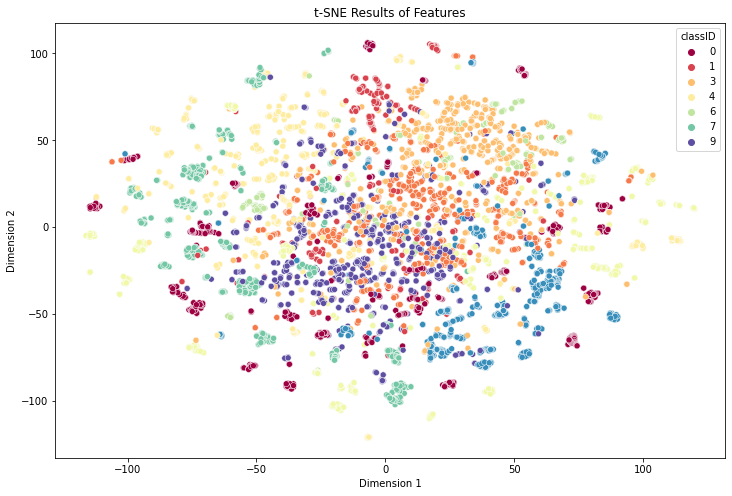

In [90]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=train_f_embedded[:, 0],
                y=train_f_embedded[:, 1], 
                hue=train_y,
                palette='Spectral')

plt.title('t-SNE Results of Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

## Pipe (make_oversampled_feature_pipeline, w/o delta, AddGausianNoise)

Don't run the cells in this section.

In [41]:
pipe2 = make_oversampled_feature_pipeline()
pipe2.set_params(
**{'estimator': XGBClassifier(learning_rate=0.05, max_depth=8,
               n_estimators=400, objective='multi:softmax'),
 'mean_mfcc__kw_args': {'sr': 16000,'n_mfcc': 16,
  'n_fft': 256,'hop_length': 128,
  'fmin': 0.0, 'fmax': 3000.0, 'n_mels': 98},
  'over_sampler': OverSampler(augment_method='AddGaussianNoise')}
)

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x14a1865e0>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x147bd8790>,
                                     kw_args={'fmax': 3000.0, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 256,
                                              'n_mels': 98, 'n_m...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, reg_alpha=None, ...))])

In [58]:
#return both x, y 
ov_train, ov_y = pipe2[:-3].fit_resample(train_fold, train_y)

In [59]:
new_x = pipe2[2:-1].fit_transform(ov_train)

### Visual -Features

In [60]:
ov_train_embedded = TSNE(n_components=2, learning_rate='auto', 
                        init='random', perplexity=12).fit_transform(new_x)

In [61]:
ov_train_embedded

array([[ 57.274994, -26.593555],
       [ 41.298943, -21.34024 ],
       [ 54.64664 , -51.20001 ],
       ...,
       [ 67.3314  ,  70.70134 ],
       [ 46.82285 ,  47.056004],
       [ 83.97625 ,  43.171642]], dtype=float32)

Text(0, 0.5, 'Dimension 2')

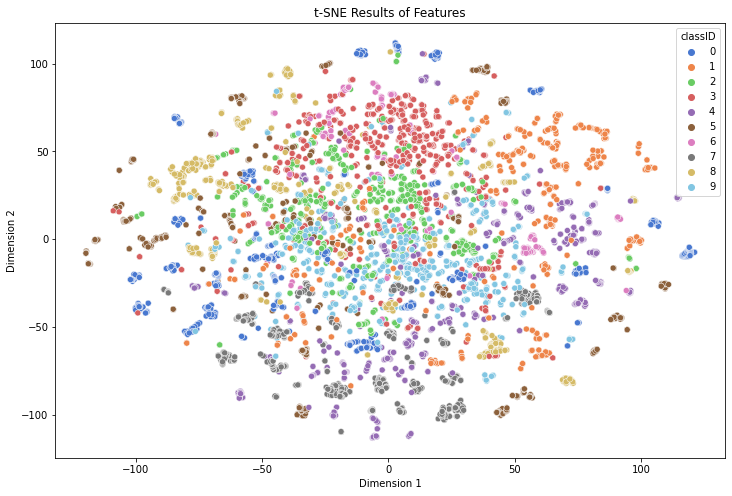

In [67]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=ov_train_embedded[:, 0],
                y=ov_train_embedded[:, 1], 
                hue=ov_y,
                palette='muted')

plt.title('t-SNE Results of Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

## Pipe (make_feature_pipe, with delta1)

In [13]:
pipe3 = mfp()
pipe3.set_params(mean_mfcc__kw_args={'delta1':True})


Pipeline(steps=[('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10f2c0550>,
                                     kw_args={'delta1': True})),
                ('scaler', StandardScaler())])

In [14]:
x = pipe3.fit_transform(train_fold, train_y)

### Visual -Features

In [15]:
x_embedded = TSNE(n_components=2, learning_rate='auto', 
                        init='random', perplexity=12).fit_transform(x)

Text(0, 0.5, 'Dimension 2')

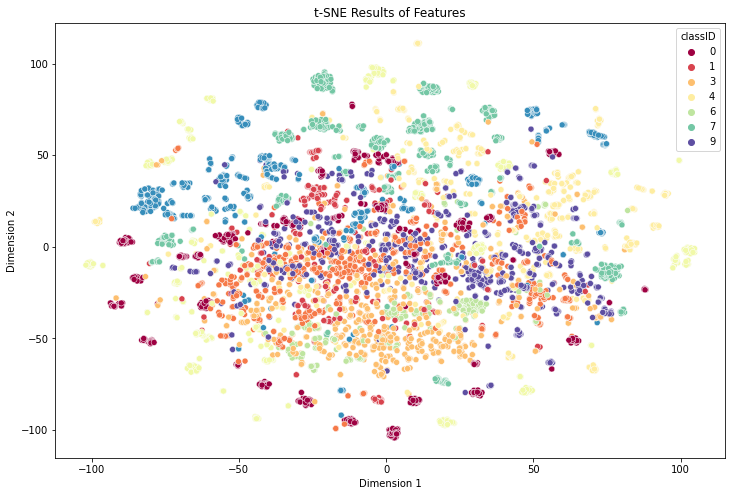

In [25]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x_embedded[:, 0],
                y=x_embedded[:, 1], 
                hue=train_y,
                palette='Spectral')

plt.title('t-SNE Results of Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

## Pipe (make_oversampeld_pipeline, with delta1, AddGaussianNoise)

In [29]:
pipe4 = make_oversampled_feature_pipeline()
pipe4.set_params(
**{'estimator': XGBClassifier(learning_rate=0.05, max_depth=8,
               n_estimators=400, objective='multi:softmax'),
 'mean_mfcc__kw_args': {"sr": 16000,
                        "n_mfcc": 20,
                        "n_fft": 512,
                        "hop_length": 128,
                        "fmin": 0.0,
                        "fmax": None,
                        "n_mels": 100,
                        "delta1": True,},
  'over_sampler': OverSampler(augment_method='AddGaussianNoise')}
)

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x14b093f70>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10f2c0550>,
                                     kw_args={'delta1': True, 'fmax': None,
                                              'fmin': 0.0, 'hop_length': 128,
                                              'n_fft': 512, 'n_m...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, reg_alpha=None, ...))])

In [31]:
x4, y4 = pipe4[:2].fit_resample(train_fold, train_y)

In [34]:
new_x4 = pipe4[2:-1].fit_transform(x4)

### Visual -Features

In [35]:
x4_embedded = TSNE(n_components=2, learning_rate='auto', 
                        init='random', perplexity=12).fit_transform(new_x4)

Text(0, 0.5, 'Dimension 2')

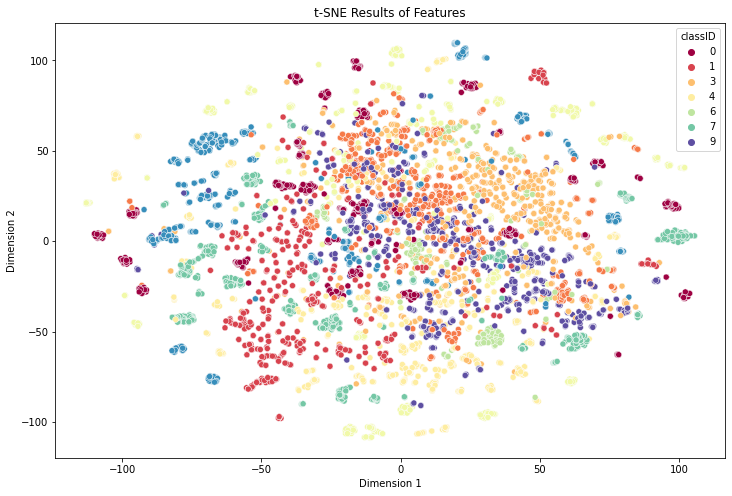

In [36]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x4_embedded[:, 0],
                y=x4_embedded[:, 1], 
                hue=y4,
                palette='Spectral')

plt.title('t-SNE Results of Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

## Pipe (make_feature_pipeline, with delta2)

In [37]:
pipe5 = mfp()
pipe5.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10f2c0550>,
                                     kw_args={'delta1': False, 'delta2': False,
                                              'fmax': None, 'fmin': 0.0,
                                              'hop_length': 128, 'n_fft': 512,
                                              'n_mels': 100, 'n_mfcc': 20,
                                              'sr': 16000})),
                ('scaler', StandardScaler())])>

In [38]:
pipe5.set_params(mean_mfcc__kw_args={'delta2':True})

Pipeline(steps=[('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10f2c0550>,
                                     kw_args={'delta2': True})),
                ('scaler', StandardScaler())])

In [40]:
x5 = pipe5.fit_transform(train_fold, train_y)

### Visual -Features

In [69]:
x5_embedded = TSNE(n_components=2, init='random', 
                   perplexity=12, learning_rate='auto').fit_transform(x5)

Text(0, 0.5, 'Dimension 2')

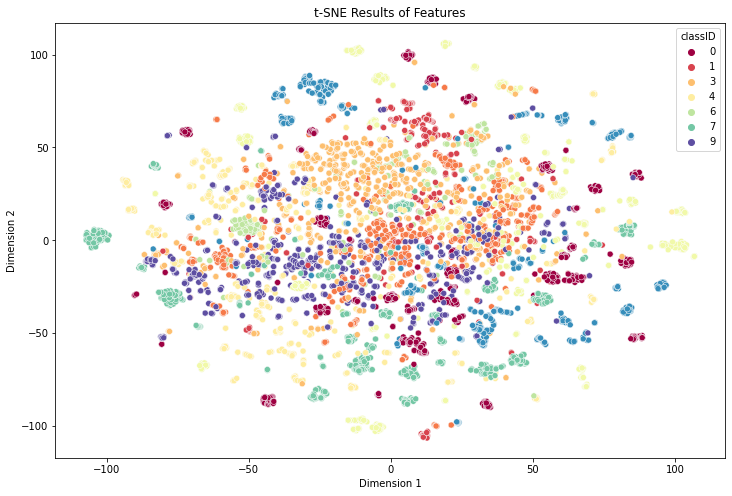

In [70]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x5_embedded[:, 0], 
                     y=x5_embedded[:, 1], 
                     hue=train_y, 
                     palette='Spectral')

plt.title('t-SNE Results of Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

## Pipe (make_oversampled_pipeline, with delta2, AddGaussianNoise)

In [43]:
pipe6 = make_oversampled_feature_pipeline()
pipe6.set_params(
**{'estimator': XGBClassifier(learning_rate=0.05, max_depth=8,
               n_estimators=400, objective='multi:softmax'),
 'mean_mfcc__kw_args': {"sr": 16000,
                        "n_mfcc": 20,
                        "n_fft": 512,
                        "hop_length": 128,
                        "fmin": 0.0,
                        "fmax": None,
                        "n_mels": 100,
                        "delta2": True,},
  'over_sampler': OverSampler(augment_method='AddGaussianNoise')}
)

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x14b093f70>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10f2c0550>,
                                     kw_args={'delta2': True, 'fmax': None,
                                              'fmin': 0.0, 'hop_length': 128,
                                              'n_fft': 512, 'n_m...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, reg_alpha=None, ...))])

In [45]:
x6, y6 = pipe6[:2].fit_resample(train_fold, train_y)

In [46]:
new_x6 = pipe6[2:-1].fit_transform(x6)

### Visual -Features

In [47]:
x6_embedded = TSNE(n_components=2, init='random', 
                   learning_rate='auto', perplexity=12).fit_transform(new_x6)

Text(0, 0.5, 'Dimension 2')

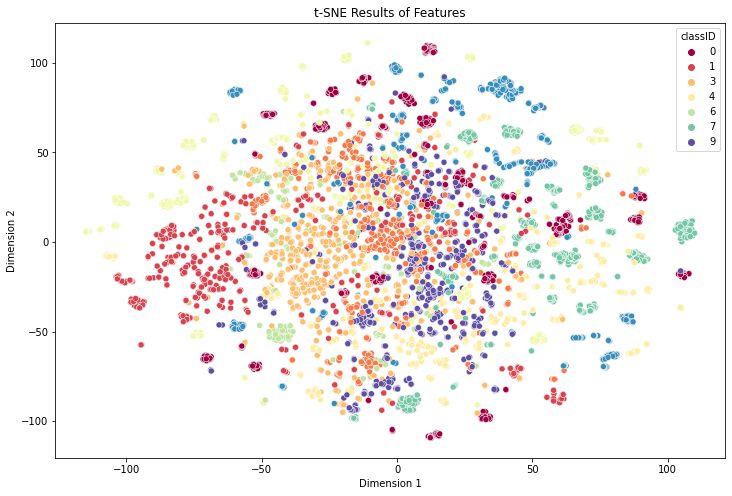

In [48]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x6_embedded[:, 0], 
                     y=x6_embedded[:, 1], 
                     hue=y6, 
                     palette='Spectral')

plt.title('t-SNE Results of Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

## Pipe (make_feature_pipeline, with both deltas)

In [52]:
pipe7 = mfp()
pipe7.set_params(mean_mfcc__kw_args={'delta1':True, 'delta2':True})

Pipeline(steps=[('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10f2c0550>,
                                     kw_args={'delta1': True, 'delta2': True})),
                ('scaler', StandardScaler())])

In [55]:
x7 = pipe7.fit_transform(train_fold, train_y)

In [73]:
x7_embedded = TSNE(n_components=2, init='random', 
                   learning_rate='auto', perplexity=12).fit_transform(x7)

Text(0, 0.5, 'Dimension 2')

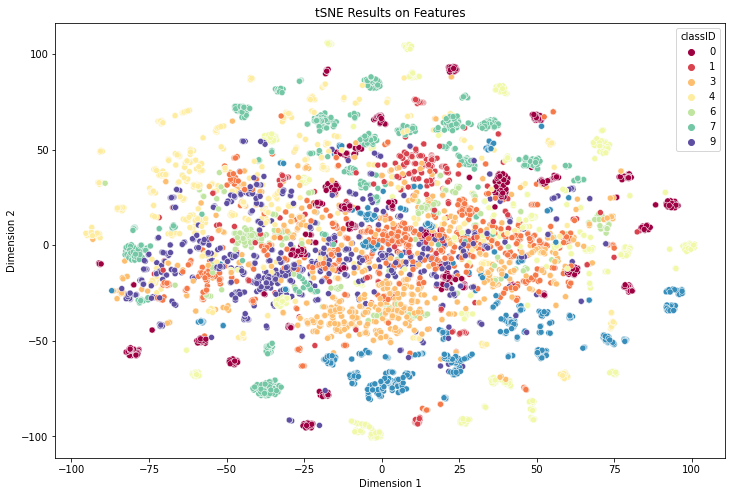

In [74]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x7_embedded[:, 0], 
                     y=x7_embedded[:, 1], 
                     hue=train_y, 
                     palette='Spectral')

plt.title('tSNE Results on Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

## Pipe (make_oversampled_pipeline, with both deltas, AddGaussianNoise)

In [77]:
pipe8 = make_oversampled_feature_pipeline()
pipe8.set_params(
 **{'estimator': XGBClassifier(learning_rate=0.05, max_depth=8,
               n_estimators=400, objective='multi:softmax'),
 'mean_mfcc__kw_args': {"sr": 16000,
                        "n_mfcc": 20,
                        "n_fft": 512,
                        "hop_length": 128,
                        "fmin": 0.0,
                        "fmax": None,
                        "n_mels": 100,
                        "delta1":True,
                        "delta2": True,},
  'over_sampler': OverSampler(augment_method='AddGaussianNoise')}   
)

Use pipe.set_params(over_sampler=.., estimator=..) to finish the pipeline


Pipeline(steps=[('pad',
                 FunctionTransformer(func=<function np_pad_wrapper at 0x14b093f70>,
                                     kw_args={'max_len': 64000})),
                ('over_sampler',
                 AugmentingRandomOversampler(sampling_strategy='minority')),
                ('mean_mfcc',
                 FunctionTransformer(func=<function samples_to_mean_mfcc at 0x10f2c0550>,
                                     kw_args={'delta1': True, 'delta2': True,
                                              'fmax': None, 'fmin': 0.0,
                                              'hop_length': 128, 'n...
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softmax', predictor=None,
                               random_state=None, reg_alpha=None, ...))])

In [79]:
x8, y8 = pipe8[:2].fit_resample(train_fold, train_y)

In [80]:
new_x8 = pipe8[2:-1].fit_transform(x8)

### Visual -Features

In [82]:
x8_embedded = TSNE(n_components=2, init='random', 
                   perplexity=12, learning_rate='auto').fit_transform(new_x8)

Text(0, 0.5, 'Dimension 2')

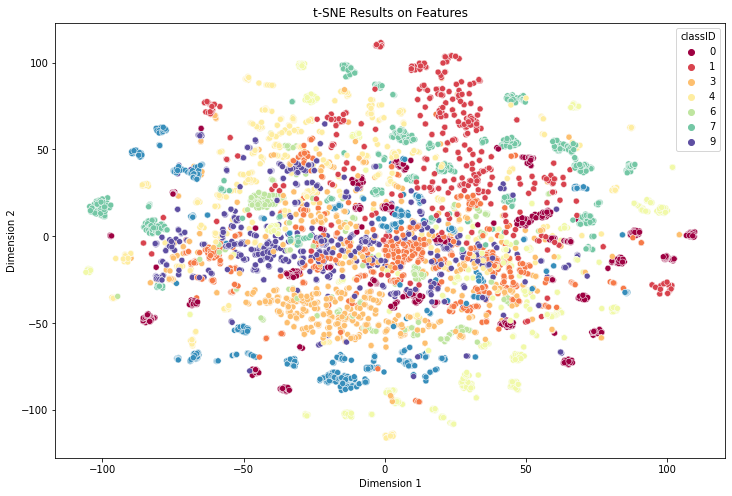

In [83]:
plt.figure(figsize=(12, 8))
ax = sns.scatterplot(x=x8_embedded[:, 0],
                     y=x8_embedded[:, 1], 
                     hue=y8,
                     palette='Spectral')

plt.title('t-SNE Results on Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

## Observation

- Features extracted using make_feature_pipeline:

  Plots have better representation when only 'delta1' is True

  (Since the 'init' arguments in TSNE is 'random', results when cells are rerun might return slightly different distributions)

- Features extracted using make_oversampled_feature_pipeline: 

  Plots have better representaton when only 'delta2' is True